<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/da_cv_fer_sfew_expw_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloning repository
Importing files regarding dataset, model, mains and utils

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 138 (delta 72), reused 70 (delta 35), pack-reused 0
Receiving objects: 100% (138/138), 4.52 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (72/72), done.


Installing dependencies

In [5]:
!pip install -q -r requirements.txt # -q is for quiet install
!pip install -q opendatasets # quient install, for some reason this does not get installed with requirements

ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306


## Libraries and Initializations

In [6]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import show_batch
from da_cv_fer.model_DANN import DANN
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import * #(weights_init, train_model,get_correct_predictions,test_model)

import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


### Initializing configs

In [7]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

## SFEW Dataset

Creating dataloader objects.

It copies files from a google drive, unzips it and sets that for use

details: da_cv_fer.ds_sfew.DatasetSFEW

In [8]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
sfew = DatasetSFEW()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew already exists.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


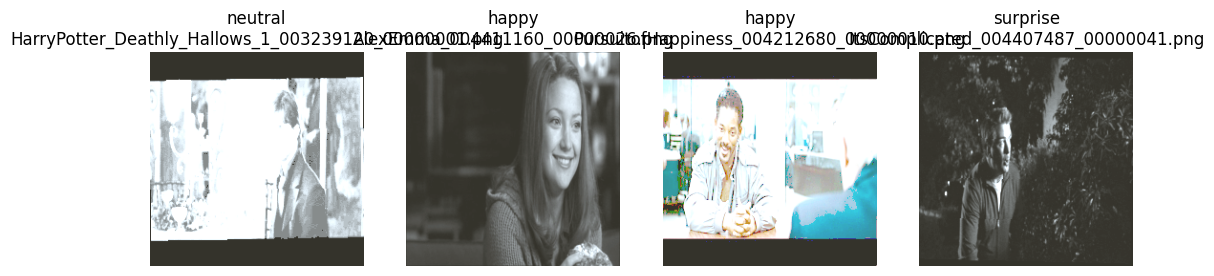

In [10]:
show_batch(sfew_train_loader,sfew.labels,4)

## EXPW Dataset
Creating dataset and dataloader objects.
Split into train and val.

`details: da_cv_fer.ds_expw.EXPW`
<br>
Please be patient, it takes around 3 minutes to download data set

In [11]:
expw_obj = EXPW()
expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
in EXPW()...
Directory dataset/expwds created successfully.


100%|██████████| 7.68G/7.68G [06:38<00:00, 20.7MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
Directory dataset/expwds already exists.
Directory dataset/expwds already exists.
 length of EXPW dataset : 54476 , 54476


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


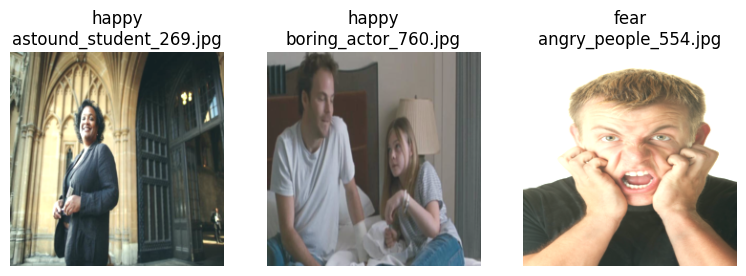

In [12]:
show_batch(expw_train_loader,expw_train_ds.labels,3)

## Creating Dataloaders for source and target

In [23]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }

expw_loader = {'name': 'expw',
               'train':expw_train_loader,
               'val':expw_val_loader
               }

data_loader = {'source' : sfew_loader,
               'target' : expw_loader}

source_name = data_loader['source']['name']
target_name = data_loader['target']['name']

## Initializing Model
details are present in `model_DANN`

In [14]:
model = DANN(num_classes=7, dropout=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)

cuda


Running model for single run. checking output shapes

In [16]:
for usage, dict_data_loader in data_loader.items(): ## {'source' : sfew_loader,'target' : expw_loader}
    print('-'*80)
    print(usage)
    for k, v in dict_data_loader.items(): # {'name': 'sfew','train':sfew_train_loader,'val':sfew_val_loader}
      if k == 'name':
        print (f'--------{k} of dataset : {v}--------')
      else:
        print (f'   --------type : {k}--------')
        batch = next(iter(v)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ", labels: ",labels.shape)

        x_labels, x_domains, x_features = model(images) # forward pass
        print("Output:\n", "labels: ", x_labels.shape, ", domains: ",x_domains.shape, ", features: ", x_features.shape)


--------------------------------------------------------------------------------
source
--------name of dataset : sfew--------
   --------type : train--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) , domains:  torch.Size([16, 2]) , features:  torch.Size([16, 1000])
   --------type : val--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) , domains:  torch.Size([16, 2]) , features:  torch.Size([16, 1000])
--------------------------------------------------------------------------------
target
--------name of dataset : expw--------
   --------type : train--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , labels:  torch.Size([16, 7])
Output:
 labels:  torch.Size([16, 7]) , domains:  torch.Size([16, 2]) , features:  torch.Size([16, 1000])
   --------type : val--------
Input:
 Input Image:  torch.Size([16, 3, 224, 224]) , l

In [14]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       # nn.init.xavier_normal_(m.weight)
#       pass # not initialising Conv layers as they are pretrained
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight) # Linear layers are added on
#       nn.init.zeros_(m.bias)

## Non DANN: Training, Validating, Saving

### Scheduler - ReduceLRonPlateau

In [18]:

# from torch.optim.lr_scheduler import ReduceLROnPlateau


# class EarlyStopping:
#     def __init__(self, patience=5, verbose=False):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_metric = float('inf')  # Adjust based on your metric (e.g., validation loss)
#         self.early_stop = False

#     def __call__(self, metric):
#         if metric < self.best_metric:
#             self.best_metric = metric
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         return self.early_stop

# class CustomModel(nn.Module):
#     # Define your model architecture here

# # Assuming you have a DataLoader for your dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# # Instantiate your model
# model = CustomModel()

# # Set up your loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)

# # Set up EarlyStopping callback
# early_stopping = EarlyStopping(patience=5, verbose=True)



#     # Adjust learning rate based on validation loss
#     scheduler.step(val_loss)

#     # Check for early stopping
#     if early_stopping(val_loss):
#         print("Early stopping")
#         break

# # Save or use the trained model



In [18]:
def early_stopping_difference(list_loss: list, patience = 5, difference = 0.0003):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1):
      if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
        return False
    return True
  else:
    return False

Configuration towards execution

In [17]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANN(num_classes=7)
non_dann_model = non_dann_model.to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr = float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = runconfig.early_stop_patience
early_stop_difference = runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              min_lr=1e-6,
                              verbose= True)

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based

EPOCHS 50


In [19]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(avg_epoch_loss) #applying scheduler on training loss

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)

    if early_stopping_difference(val_losses,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

correct, test_loss_source = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)

correct, test_loss_target = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = data_loader['target']['val'], # target val loader
                                    class_loss_function = criterion_class)

dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}




------ Training started for Non DANN Model ---- 
starting LR : 0.001
EPOCH: 1  of  50
epoch = 1...in training function


Loss=1.9464101791381836 Accuracy=151/958(15.76%) Epoch Avg loss=0.12330554 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Test / Val: Average loss: 0.1258, Accuracy: 83/436 (19.04%)

EPOCH: 2  of  50
epoch = 2...in training function


Loss=1.8045915365219116 Accuracy=207/958(21.61%) Epoch Avg loss=0.11797007 LR=0.001000: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Test / Val: Average loss: 0.1254, Accuracy: 77/436 (17.66%)

EPOCH: 3  of  50
epoch = 3...in training function


Loss=1.8353382349014282 Accuracy=241/958(25.16%) Epoch Avg loss=0.11622669 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Test / Val: Average loss: 0.1261, Accuracy: 89/436 (20.41%)

EPOCH: 4  of  50
epoch = 4...in training function


Loss=1.6712186336517334 Accuracy=230/958(24.01%) Epoch Avg loss=0.11352293 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.42it/s]


Test / Val: Average loss: 0.1267, Accuracy: 83/436 (19.04%)

EPOCH: 5  of  50
epoch = 5...in training function


Loss=1.9679505825042725 Accuracy=265/958(27.66%) Epoch Avg loss=0.11257151 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.25it/s]


Test / Val: Average loss: 0.1275, Accuracy: 78/436 (17.89%)

EPOCH: 6  of  50
epoch = 6...in training function


Loss=1.8526817560195923 Accuracy=276/958(28.81%) Epoch Avg loss=0.11000597 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.38it/s]


Test / Val: Average loss: 0.1266, Accuracy: 88/436 (20.18%)

EPOCH: 7  of  50
epoch = 7...in training function


Loss=1.6473358869552612 Accuracy=299/958(31.21%) Epoch Avg loss=0.10917708 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.39it/s]


Test / Val: Average loss: 0.1295, Accuracy: 83/436 (19.04%)

EPOCH: 8  of  50
epoch = 8...in training function


Loss=1.9336782693862915 Accuracy=313/958(32.67%) Epoch Avg loss=0.10777173 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Test / Val: Average loss: 0.1308, Accuracy: 84/436 (19.27%)

EPOCH: 9  of  50
epoch = 9...in training function


Loss=1.9844796657562256 Accuracy=318/958(33.19%) Epoch Avg loss=0.10573930 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.17it/s]


Test / Val: Average loss: 0.1314, Accuracy: 82/436 (18.81%)

EPOCH: 10  of  50
epoch = 10...in training function


Loss=2.0163583755493164 Accuracy=356/958(37.16%) Epoch Avg loss=0.10274840 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.45it/s]


Test / Val: Average loss: 0.1298, Accuracy: 83/436 (19.04%)

EPOCH: 11  of  50
epoch = 11...in training function


Loss=1.5166095495224 Accuracy=370/958(38.62%) Epoch Avg loss=0.10186658 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Test / Val: Average loss: 0.1317, Accuracy: 89/436 (20.41%)

EPOCH: 12  of  50
epoch = 12...in training function


Loss=1.6131587028503418 Accuracy=397/958(41.44%) Epoch Avg loss=0.09785881 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.16it/s]


Test / Val: Average loss: 0.1310, Accuracy: 80/436 (18.35%)

EPOCH: 13  of  50
epoch = 13...in training function


Loss=1.7231251001358032 Accuracy=373/958(38.94%) Epoch Avg loss=0.09763305 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.34it/s]


Test / Val: Average loss: 0.1342, Accuracy: 93/436 (21.33%)

EPOCH: 14  of  50
epoch = 14...in training function


Loss=1.5836195945739746 Accuracy=425/958(44.36%) Epoch Avg loss=0.09144309 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.42it/s]


Test / Val: Average loss: 0.1388, Accuracy: 78/436 (17.89%)

EPOCH: 15  of  50
epoch = 15...in training function


Loss=1.5404893159866333 Accuracy=449/958(46.87%) Epoch Avg loss=0.09091244 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.41it/s]


Test / Val: Average loss: 0.1356, Accuracy: 83/436 (19.04%)

EPOCH: 16  of  50
epoch = 16...in training function


Loss=1.3157479763031006 Accuracy=493/958(51.46%) Epoch Avg loss=0.08398994 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.14it/s]


Test / Val: Average loss: 0.1351, Accuracy: 96/436 (22.02%)

EPOCH: 17  of  50
epoch = 17...in training function


Loss=1.4770963191986084 Accuracy=476/958(49.69%) Epoch Avg loss=0.08647648 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.38it/s]


Test / Val: Average loss: 0.1361, Accuracy: 93/436 (21.33%)

EPOCH: 18  of  50
epoch = 18...in training function


Loss=1.212544322013855 Accuracy=508/958(53.03%) Epoch Avg loss=0.08114197 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.34it/s]


Test / Val: Average loss: 0.1377, Accuracy: 103/436 (23.62%)

EPOCH: 19  of  50
epoch = 19...in training function


Loss=1.2811297178268433 Accuracy=543/958(56.68%) Epoch Avg loss=0.07598166 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.38it/s]


Test / Val: Average loss: 0.1318, Accuracy: 104/436 (23.85%)

EPOCH: 20  of  50
epoch = 20...in training function


Loss=0.8016749620437622 Accuracy=553/958(57.72%) Epoch Avg loss=0.07280800 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.38it/s]


Test / Val: Average loss: 0.1375, Accuracy: 85/436 (19.50%)

EPOCH: 21  of  50
epoch = 21...in training function


Loss=0.9263136982917786 Accuracy=572/958(59.71%) Epoch Avg loss=0.07066787 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.03it/s]


Test / Val: Average loss: 0.1337, Accuracy: 107/436 (24.54%)

EPOCH: 22  of  50
epoch = 22...in training function


Loss=1.2091655731201172 Accuracy=636/958(66.39%) Epoch Avg loss=0.06423340 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.35it/s]


Test / Val: Average loss: 0.1404, Accuracy: 107/436 (24.54%)

EPOCH: 23  of  50
epoch = 23...in training function


Loss=0.6181191205978394 Accuracy=623/958(65.03%) Epoch Avg loss=0.06386608 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Test / Val: Average loss: 0.1372, Accuracy: 98/436 (22.48%)

EPOCH: 24  of  50
epoch = 24...in training function


Loss=1.145748496055603 Accuracy=648/958(67.64%) Epoch Avg loss=0.05908961 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Test / Val: Average loss: 0.1380, Accuracy: 115/436 (26.38%)

EPOCH: 25  of  50
epoch = 25...in training function


Loss=0.8112463355064392 Accuracy=663/958(69.21%) Epoch Avg loss=0.05556949 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.34it/s]


Test / Val: Average loss: 0.1418, Accuracy: 102/436 (23.39%)

EPOCH: 26  of  50
epoch = 26...in training function


Loss=1.2165162563323975 Accuracy=676/958(70.56%) Epoch Avg loss=0.05386369 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Test / Val: Average loss: 0.1456, Accuracy: 104/436 (23.85%)

EPOCH: 27  of  50
epoch = 27...in training function


Loss=0.7508519291877747 Accuracy=717/958(74.84%) Epoch Avg loss=0.04744202 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Test / Val: Average loss: 0.1519, Accuracy: 103/436 (23.62%)

EPOCH: 28  of  50
epoch = 28...in training function


Loss=1.2524937391281128 Accuracy=741/958(77.35%) Epoch Avg loss=0.04637149 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.33it/s]


Test / Val: Average loss: 0.1552, Accuracy: 96/436 (22.02%)

EPOCH: 29  of  50
epoch = 29...in training function


Loss=0.8972281217575073 Accuracy=741/958(77.35%) Epoch Avg loss=0.04384147 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Test / Val: Average loss: 0.1556, Accuracy: 94/436 (21.56%)

EPOCH: 30  of  50
epoch = 30...in training function


Loss=0.9838376045227051 Accuracy=737/958(76.93%) Epoch Avg loss=0.04197527 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.17it/s]


Test / Val: Average loss: 0.1491, Accuracy: 117/436 (26.83%)

EPOCH: 31  of  50
epoch = 31...in training function


Loss=0.9469283223152161 Accuracy=745/958(77.77%) Epoch Avg loss=0.04190071 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.34it/s]


Test / Val: Average loss: 0.1445, Accuracy: 108/436 (24.77%)

EPOCH: 32  of  50
epoch = 32...in training function


Loss=0.8318930268287659 Accuracy=775/958(80.90%) Epoch Avg loss=0.03730151 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.34it/s]


Test / Val: Average loss: 0.1646, Accuracy: 105/436 (24.08%)

EPOCH: 33  of  50
epoch = 33...in training function


Loss=0.44568192958831787 Accuracy=781/958(81.52%) Epoch Avg loss=0.03546182 LR=0.001000: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Test / Val: Average loss: 0.1555, Accuracy: 98/436 (22.48%)

EPOCH: 34  of  50
epoch = 34...in training function


Loss=0.7387778759002686 Accuracy=804/958(83.92%) Epoch Avg loss=0.03174094 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Test / Val: Average loss: 0.1652, Accuracy: 98/436 (22.48%)

EPOCH: 35  of  50
epoch = 35...in training function


Loss=0.43809425830841064 Accuracy=812/958(84.76%) Epoch Avg loss=0.03180191 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Test / Val: Average loss: 0.1618, Accuracy: 107/436 (24.54%)

EPOCH: 36  of  50
epoch = 36...in training function


Loss=0.40334662795066833 Accuracy=802/958(83.72%) Epoch Avg loss=0.03080869 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.42it/s]


Test / Val: Average loss: 0.1644, Accuracy: 91/436 (20.87%)

EPOCH: 37  of  50
epoch = 37...in training function


Loss=0.3060528635978699 Accuracy=814/958(84.97%) Epoch Avg loss=0.02847159 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Test / Val: Average loss: 0.1615, Accuracy: 117/436 (26.83%)

EPOCH: 38  of  50
epoch = 38...in training function


Loss=0.4965110719203949 Accuracy=829/958(86.53%) Epoch Avg loss=0.02839829 LR=0.001000: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Test / Val: Average loss: 0.1580, Accuracy: 106/436 (24.31%)

EPOCH: 39  of  50
epoch = 39...in training function


Loss=0.23410369455814362 Accuracy=844/958(88.10%) Epoch Avg loss=0.02444726 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.35it/s]


Test / Val: Average loss: 0.1630, Accuracy: 113/436 (25.92%)

EPOCH: 40  of  50
epoch = 40...in training function


Loss=0.5071501135826111 Accuracy=863/958(90.08%) Epoch Avg loss=0.02110543 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.28it/s]


Test / Val: Average loss: 0.1590, Accuracy: 105/436 (24.08%)

EPOCH: 41  of  50
epoch = 41...in training function


Loss=0.4483630955219269 Accuracy=844/958(88.10%) Epoch Avg loss=0.02311893 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.39it/s]


Test / Val: Average loss: 0.1557, Accuracy: 114/436 (26.15%)

EPOCH: 42  of  50
epoch = 42...in training function


Loss=0.35009199380874634 Accuracy=849/958(88.62%) Epoch Avg loss=0.02161943 LR=0.001000: 100%|██████████| 60/60 [00:18<00:00,  3.28it/s]


Test / Val: Average loss: 0.1530, Accuracy: 126/436 (28.90%)

EPOCH: 43  of  50
epoch = 43...in training function


Loss=0.30508819222450256 Accuracy=837/958(87.37%) Epoch Avg loss=0.02386247 LR=0.001000: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Test / Val: Average loss: 0.1664, Accuracy: 105/436 (24.08%)

EPOCH: 44  of  50
epoch = 44...in training function


Loss=0.31613636016845703 Accuracy=861/958(89.87%) Epoch Avg loss=0.02206167 LR=0.001000: 100%|██████████| 60/60 [00:17<00:00,  3.40it/s]

Epoch 00044: reducing learning rate of group 0 to 2.0000e-04.


Test / Val: Average loss: 0.1583, Accuracy: 121/436 (27.75%)

EPOCH: 45  of  50
epoch = 45...in training function


Loss=0.07975760102272034 Accuracy=869/958(90.71%) Epoch Avg loss=0.01859631 LR=0.000200: 100%|██████████| 60/60 [00:17<00:00,  3.43it/s]


Test / Val: Average loss: 0.1592, Accuracy: 123/436 (28.21%)

EPOCH: 46  of  50
epoch = 46...in training function


Loss=0.3672662079334259 Accuracy=891/958(93.01%) Epoch Avg loss=0.01476565 LR=0.000200: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Test / Val: Average loss: 0.1573, Accuracy: 113/436 (25.92%)

EPOCH: 47  of  50
epoch = 47...in training function


Loss=0.15393537282943726 Accuracy=878/958(91.65%) Epoch Avg loss=0.01822665 LR=0.000200: 100%|██████████| 60/60 [00:17<00:00,  3.36it/s]


Test / Val: Average loss: 0.1553, Accuracy: 116/436 (26.61%)

EPOCH: 48  of  50
epoch = 48...in training function


Loss=0.16147959232330322 Accuracy=891/958(93.01%) Epoch Avg loss=0.01440443 LR=0.000200: 100%|██████████| 60/60 [00:17<00:00,  3.34it/s]


Test / Val: Average loss: 0.1579, Accuracy: 115/436 (26.38%)

EPOCH: 49  of  50
epoch = 49...in training function


Loss=0.346889853477478 Accuracy=894/958(93.32%) Epoch Avg loss=0.01437361 LR=0.000200: 100%|██████████| 60/60 [00:19<00:00,  3.15it/s]


Test / Val: Average loss: 0.1609, Accuracy: 120/436 (27.52%)

EPOCH: 50  of  50
epoch = 50...in training function


Loss=0.5066624879837036 Accuracy=886/958(92.48%) Epoch Avg loss=0.01485611 LR=0.000200: 100%|██████████| 60/60 [00:17<00:00,  3.39it/s]


Test / Val: Average loss: 0.1598, Accuracy: 119/436 (27.29%)

Test / Val: Average loss: 0.1606, Accuracy: 119/436 (27.29%)

Test / Val: Average loss: 0.1720, Accuracy: 3301/13620 (24.24%)



In [24]:
print(dict_non_dann_losses)

{'train_losses': [0.12330554, 0.11797007, 0.11622669, 0.11352293, 0.11257151, 0.11000597, 0.10917708, 0.10777173, 0.1057393, 0.1027484, 0.10186658, 0.09785881, 0.09763305, 0.09144309, 0.09091244, 0.08398994, 0.08647648, 0.08114197, 0.07598166, 0.072808, 0.07066787, 0.0642334, 0.06386608, 0.05908961, 0.05556949, 0.05386369, 0.04744202, 0.04637149, 0.04384147, 0.04197527, 0.04190071, 0.03730151, 0.03546182, 0.03174094, 0.03180191, 0.03080869, 0.02847159, 0.02839829, 0.02444726, 0.02110543, 0.02311893, 0.02161943, 0.02386247, 0.02206167, 0.01859631, 0.01476565, 0.01822665, 0.01440443, 0.01437361, 0.01485611], 'val_losses': [0.12581604363721446, 0.12538879699663286, 0.1260579715081311, 0.12668114791222668, 0.12753657299444215, 0.1265996801196982, 0.12951332795510598, 0.1307896247150701, 0.13138468030395858, 0.12978146218378608, 0.13171681543008998, 0.13100999210952619, 0.13419084373964082, 0.1388114761868748, 0.13562593301501844, 0.13508134260090118, 0.13612238365575807, 0.1377297013724615

In [ ]:
#@title Plotting Training and Validation Loss Function
def plot_loss_curves(dict_losses, mode = "train_losses"):
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(5, 1, 2)
    # for embedding in dict_emb_file.keys():
    list1_to_plot= dict_losses[mode]
    plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel(str(mode), fontsize=10)
    plt.legend(loc = 'upper right')
    plt.title(" "+mode)
    plt.show()

In [ ]:
plot_loss_curves(dict_non_dann_losses,mode='train_losses')
plot_loss_curves(dict_non_dann_losses,mode='val_losses')
plot_loss_curves(dict_non_dann_losses,mode='lr')

### Saving NON DANN Model

In [33]:
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [35]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(non_dann_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw created successfully.


In [43]:
# #@title Plotting Training and Validation Loss Function
# def plot_loss_curves(dict_non_dann_losses_list, mode = "train_losses"):
#     fig=plt.figure(figsize=(10,20))
#     fig.add_subplot(5, 1, 2)
#     # for embedding in dict_emb_file.keys():
#     list1_to_plot= dict_non_dann_losses_list[mode]
#     plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
#     plt.xlabel('number of epochs', fontsize=10)
#     plt.ylabel(str(mode), fontsize=10)
#     plt.legend(loc = 'upper right')
#     plt.title(" "+mode)
#     plt.show()

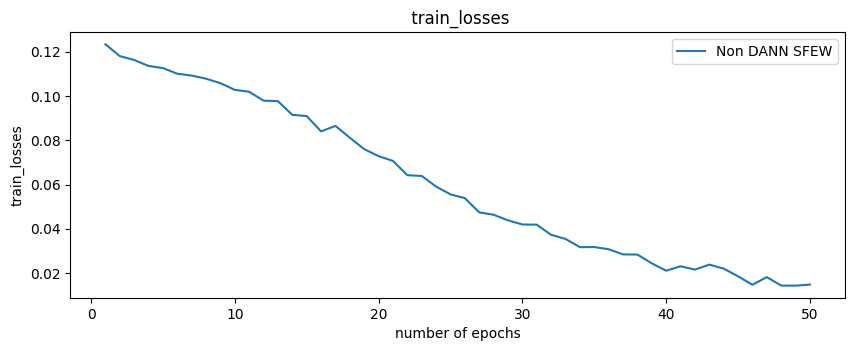

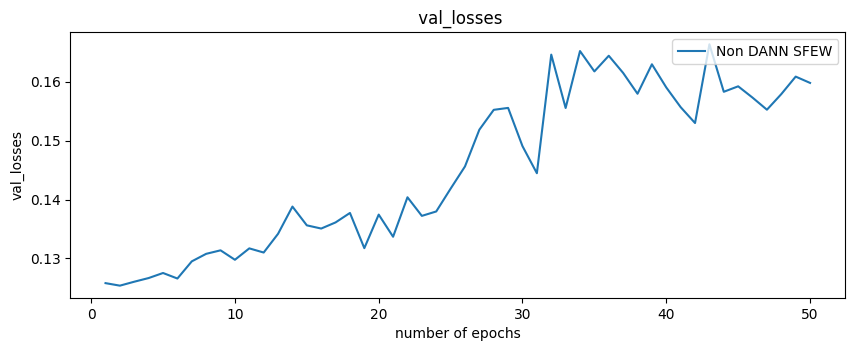

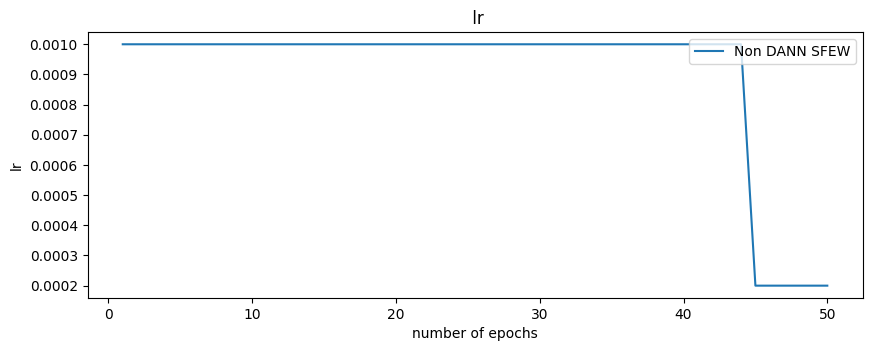

In [44]:
# plot_loss_curves(dict_non_dann_losses_list,mode='train_losses')
# plot_loss_curves(dict_non_dann_losses_list,mode='val_losses')
# plot_loss_curves(dict_non_dann_losses_list,mode='lr')

In [ ]:
# model_name = model_name #"non_dann_sfew_19_12.pt"

## Loading NON DANN Model for DANN and DANN EWC


In [70]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required

In [71]:
MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

loaded_model_non_dann = DANN(num_classes=7) # skeleton copy
loaded_model_non_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

# loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = loaded_model_non_dann # saves training time - check with all
model_dann_ewc = loaded_model_non_dann # saves training time - check with all

# print(model_dann)

In [72]:
# #checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
# print ('True')

## DANN Execution :  Training, Validating, Saving


In [73]:

def execute_dann(model,device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss() ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = epoch
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)


        #TODO: Early Stopping

    # Testing when the training is over - completed or early stopped
    correct, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha  }

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses





In [74]:
lr_dann = runconfig.inital_lr
lr_dann = lr_dann / 5.0 # OVERRIDE
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
# n_epochs = 2 #OVERRIDE
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain )

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/50] Step [1/60]: loss_total=1.5128 / domain_loss_target=0.7621 / domain_loss_source=0.6678 / task_loss=0.0829 / domain_loss=0.7507 / alpha=0.0000
Epoch [1/50] Step [11/60]: loss_total=1.5741 / domain_loss_target=0.7780 / domain_loss_source=0.6339 / task_loss=0.1622 / domain_loss=0.7961 / alpha=0.0167
Epoch [1/50] Step [21/60]: loss_total=1.5903 / domain_loss_target=0.7806 / domain_loss_source=0.6429 / task_loss=0.1669 / domain_loss=0.8098 / alpha=0.0333
Epoch [1/50] Step [31/60]: loss_total=1.5023 / domain_loss_target=0.7615 / domain_loss_source=0.6767 / task_loss=0.0642 / domain_loss=0.7408 / alpha=0.0500
Epoch [1/50] Step [41/60]: loss_total=1.6632 / domain_loss_target=0.7275 / domain_loss_source=0.6672 / task_loss=0.2685 / domain_loss=0.9357 / alpha=0.0666
Epoch [1/50] Step [51/60]: loss_total=1.5190 / domain_loss_target=0.7635 / domain_loss_source=0.6712 / task_loss=0.0844 / domain_loss=0.7556 / alpha=0.0831
Test / Val: Average loss: 0.1679, Accuracy: 116/436 (26.61%)

epo

In [75]:
dict_dann_losses

{'train_losses': [0.013281,
  0.014509,
  0.015305,
  0.012483,
  0.015033,
  0.015527,
  0.012673,
  0.01414,
  0.01134,
  0.013503,
  0.012407,
  0.013048,
  0.012416,
  0.01044,
  0.012269,
  0.0119,
  0.011251,
  0.010915,
  0.010136,
  0.011644,
  0.011415,
  0.010379,
  0.010657,
  0.011341,
  0.009203,
  0.010722,
  0.008808,
  0.010784,
  0.008391,
  0.009814,
  0.008131,
  0.008045,
  0.010448,
  0.010227,
  0.008712,
  0.009237,
  0.008682,
  0.009161,
  0.008264,
  0.008398,
  0.007805,
  0.006619,
  0.007408,
  0.007023,
  0.00903,
  0.008004,
  0.007626,
  0.007669,
  0.007149,
  0.006846],
 'val_losses': [0.16789409764316104,
  0.16959549828406867,
  0.16869186015304075,
  0.16906245039143694,
  0.16603519993090848,
  0.16936636955366222,
  0.17478435766806297,
  0.17345353605550365,
  0.1762897295689364,
  0.1773920277936743,
  0.17444301936604562,
  0.1836695676549859,
  0.16950446421946955,
  0.17363422671589282,
  0.16987786489889162,
  0.17452558027494938,
  0.178979

### DANN Plotting and Validation

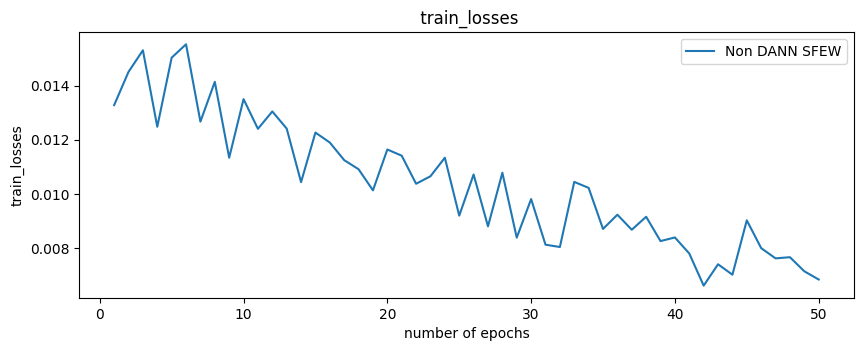

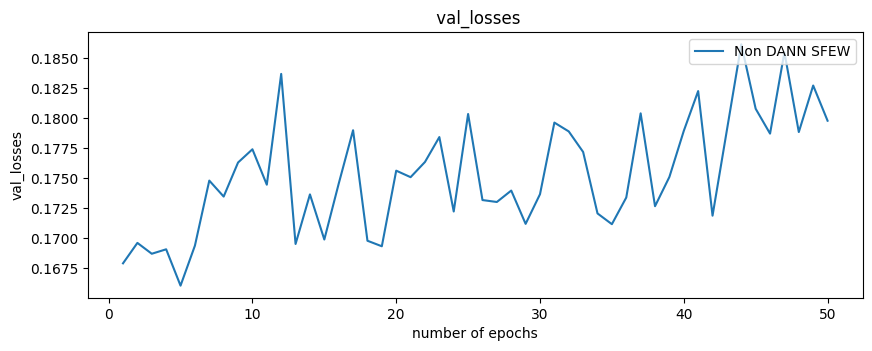

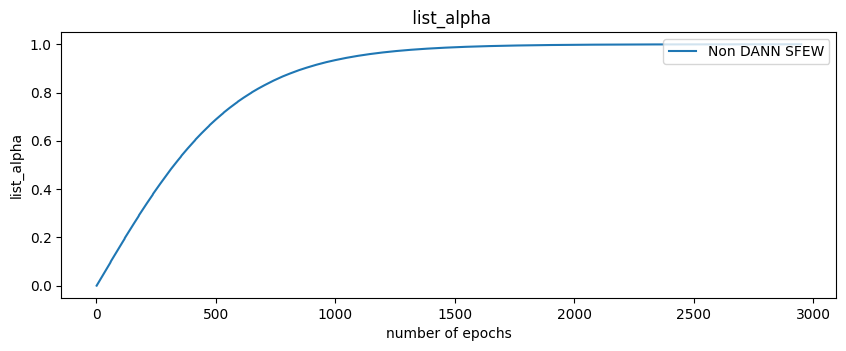

In [76]:
plot_loss_curves(dict_dann_losses,mode='train_losses')
plot_loss_curves(dict_dann_losses,mode='val_losses')
plot_loss_curves(dict_dann_losses,mode='list_alpha')

### Saving DANN Model

In [77]:
model_dann

DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [78]:
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR
MODEL_DIR

PosixPath('/content/gdrive/MyDrive/CV_FER/models')

In [79]:

dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))
# try:
#     DANN_SFEW_EXPW_DIR = Path(dataconfig_1.DANN_SFEW_EXPW_DIR)
# except:
#     DANN_SFEW_EXPW_DIR =Path(dataconfig_1.MODEL_DIR,"dann_sfew_expw")


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(model_dann.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')


dann_sfew_expw_30_01.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_30_01.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_30_01.pt!


## DANN EWC : Training, Validating, Saving

In [80]:
# dataconfig_inference = DataConfig()

# # NON DANN
# non_dann_model_sfew_name = 'non_dann_sfew_20_01.pt'
# non_dann_model_inference = DANN(num_classes=7) # skeleton copy
# NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR # Path(self.MODEL_DIR,"non_dann_sfew")

# try:
#     non_dann_model.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_name),
#                                                         map_location=torch.device(device)))
#     print(f'{non_dann_model_sfew_name} locked and loaded')
# except:
#     print(f' problem in loading {non_dann_model_sfew_name}')


In [81]:
# model_dann_ewc = non_dann_model # saves training time - check with all


In [82]:
model_dann_ewc

DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

### EWC Code
Regularization Penalty

In [83]:

from torch.autograd import Variable
from torch.autograd import Function

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

**DANN EWC Object.**

In [84]:
ewc_object = EWC(deepcopy(model_dann_ewc),
                 data_loader=data_loader['source']['train'],#sfew_train_loader,
                 device=device,
                 class_loss_function=runconfig.criterion_class)

### DANN EWC Execution (training and testing) Function without Learning rate


In [ ]:

def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = n_epochs
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model)
    model = deepcopy(model).to(device) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    ewc_object = EWC(deepcopy(model),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)


        #TODO: Early Stopping

    # Testing when the training is over - completed or early stopped
    correct_source, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target  }

    print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses





### DANN EWC Execute

In [ ]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr/5.0 #override
optimizer_ewc_dann = optim.SGD(model_dann.parameters(), lr = lr_ewc_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
# n_epochs = 2 # override
try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)

print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model=model_dann,
                                                                                  device=device,
                                                                                  source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                                                  source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                                                  target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                                                  target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                                                  optimizer = optimizer_ewc_dann,
                                                                                  n_epochs = n_epochs,
                                                                                  class_loss_function = runconfig.criterion_class,
                                                                                  domain_loss_function = runconfig.criterion_domain,
                                                                                  EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                                                )

### DANN EWC Plotting and Validation

In [ ]:
dict_ewc_dann_losses['test_loss_source'], dict_ewc_dann_losses['test_loss_target']

In [ ]:
plot_loss_curves(dict_ewc_dann_losses,mode='train_losses')
plot_loss_curves(dict_ewc_dann_losses,mode='val_losses')
plot_loss_curves(dict_ewc_dann_losses,mode='list_alpha')

### Saving DANN EWC Model

In [ ]:
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))
# try:
#     EWC_DANN_SFEW_EXPW_DIR = Path(dataconfig_2.EWC_DANN_SFEW_EXPW_DIR)
# except:
#     EWC_DANN_SFEW_EXPW_DIR =Path(dataconfig_2.MODEL_DIR,"ewc_dann_sfew_expw")


if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_SFEW_EXPW_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')
